# Nucleon Decay Sensitivity Theia

### Assumptions
1. Backgrounds uncorrelated (so we can margenalize)

### Backgrounds
1. Radioactive contamination
2. Atmospherics
3. Muon-induced
4. Solar

### Differences from Bob (maybe)
1. An assumption was made that: "depth and cleanliness are sufficient to render internal contaminants and muon spallation products irrelevant". This is not true for Hyper-K.

### Input parameters

#### $p \rightarrow e^+ \pi^0$
| Detector | Fiducial Mass | Signal Efficiency | Bkg /Mton-year | Neutron Tag | Start Date |
| -------- | ------------- | ----------------- | -------------- | ----------- | ---------- |
| Theia    | 17/80 kT      | 40 %              | 0.326          | 100%        | 2026       |
| Super-K  | 20.5 kT       | 40 %              | 2.0            | 0%          | Long ago   |
| Sk-Gd    | 20.5 kT       | 40 %              | 0.456          | 90%         | 2020?      |
| Hyper-K  | 187 kT        | 38 %              | 0.68           | 73%         | 2026       |
| Dune     | 40 kT         | 30 %              | 1.0            | xx %        | 2026       |
| Juno     | 20 kT         | --                | --             | --          | 2020       |

#### $p \rightarrow \bar{\nu} K^+$
| Detector | Fiducial Mass | Signal Efficiency | Bkg /Mton-year |
| -------- | ------------- | ----------------- | -------------- |
| Theia    |
| Super-K  |
| Sk-Gd    |
| Hyper-K  |
| Dune     | 40 kt         | 97 %              | 1.0            |
| JUNO     | 20 kt         | 55 %              | 2.5

In [1]:
## Import cell
##%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
import matplotlib.dates as dates
import datetime

In [2]:
## Setup cell
#plt.style.use('snoplus_slides')
plt.style.use('snoplus')
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize']=[10,8]
plt.rc('text', usetex=True)

# Last paper:
# https://arxiv.org/pdf/1409.5864.pdf

# Define physics parameters for the three detectors, Dune, Hyperk, Theia
class detector:
    def __init__(self, **kwargs):
        self.name = kwargs.get('name', 'Watchman')
        self.mass = kwargs.get('mass', 1) # kTons (fiducial)
        self.neutronTime = kwargs.get('neutronTime', 200) #Capture time, micro-s
        self.neutronEff = kwargs.get('neutronEfficiency', 0.20)
        self.efficiency = kwargs.get('efficiency', 0.40)
        
        self.backgroundRate = kwargs.get('backgroundRate', 10) # Events per year
        self.startTime = kwargs.get('startTime', 0)
        self.stopTime = kwargs.get('stopTime', 100)
        self.s = kwargs.get('s', np.linspace(0,0.1,20001))
        self.norm = kwargs.get('norm', 1e32)
        self.scale = kwargs.get('scale', 1)
    
    def getSensitivityCurve(self, t, **kwargs):
        # time t is in years
        # Sensitivity could be calculated a few different ways
        # poisson, s/root(b), feldmann-cousins, all using medians
        pdf = kwargs.get('pdf', 'poisson')
        
        k = self.scale
        normal = lambda s, b, n: np.e**(-(n-s-b)**2/2/(s+b))
        if pdf == 'poisson':
            normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
        s = self.s
        nt = t.copy()
        ## Now with time, v should go down
        nt[nt>self.stopTime] = self.stopTime
        S, T = np.meshgrid(s, nt-self.startTime)
        F = normal(S*T*self.efficiency*self._massToFreeProtons(**kwargs)/self.norm, self.backgroundRate*T, self.backgroundRate*T)
        F = np.nan_to_num(F)
        F = ( F.T / np.sum(F.T, axis=0) ).T
        F = np.nan_to_num(F)
        #
        self.s = s
        self.likelihood = F
        results = self._likelihoodToSens()
        
        return results
    
    def _likelihoodToSens(self):
        s = self.s
        F = self.likelihood
        L = np.cumsum(F, axis=1)
        V = s[np.argmax(L>0.9, axis=1)]*self.scale
        self.V = V
        return self.norm / (V)
    
    def _massToFreeProtons(self, **kwargs):
        mol = kwargs.get('mol', 18.01528)
        protons = kwargs.get('protons', 10)
        n_a = 6.022e23
        molecules = self.mass*1e9 / mol * n_a
        totalProtons = molecules * protons
        self.tp=totalProtons
        return totalProtons
    
    def combinedResults(self, other):
        if type(other) is not list:
            F = self.likelihood * other.likelihood
        else:
            F = self.likelihood
            for oth in other:
                F *= oth.likelihood
        F = np.nan_to_num(F)
        F = ( F.T / np.sum(F.T, axis=0) ).T
        L = np.cumsum(F, axis=1)
        V = self.s[np.argmax(L>0.9, axis=1)]*self.scale
        return self.norm / V

def savefig(name):
    plt.savefig(f'pics/{name}')
    
## Colors
clrs = {
    'hk':'xkcd:orange',
    'sk':'xkcd:black',
    'dune':'xkcd:grass green',
    'juno':'xkcd:bright purple',
    'theia':'xkcd:bright blue',
    'combined':'xkcd:red'
}

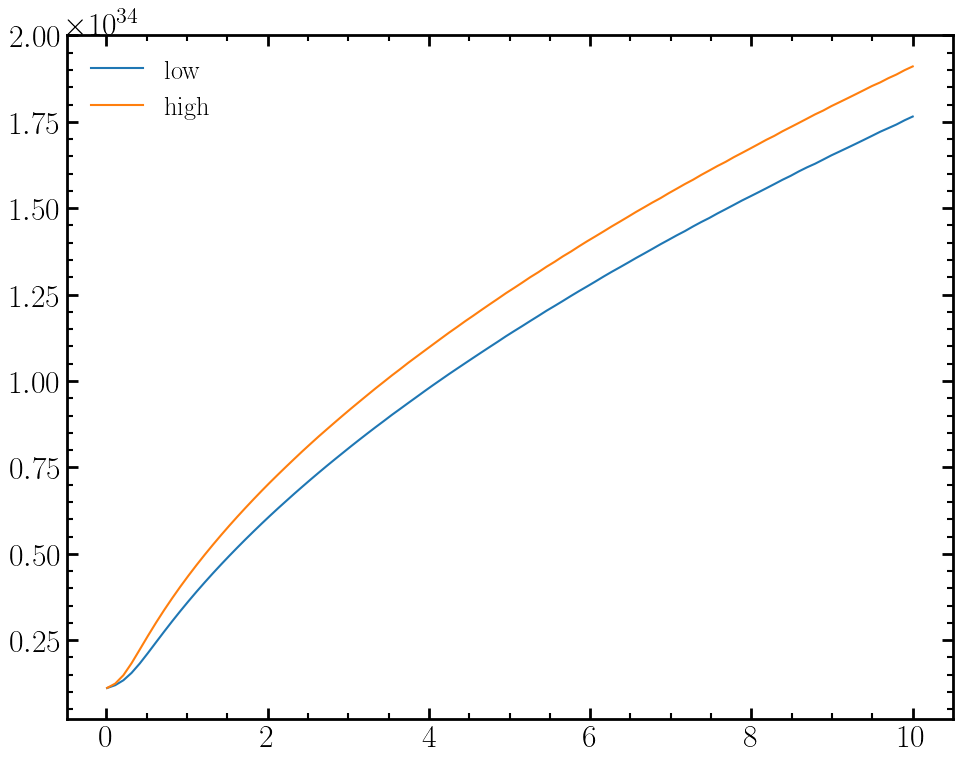

In [3]:
t = np.linspace(1e-2, 10, 100)
low = detector(name='low', mass=100, backgroundRate=1.0, startTime=0, efficiency=0.35)
v = low.getSensitivityCurve(t)
plt.plot(t, v, label='low')
high = detector(name='high', mass=100, backgroundRate=2.0, startTime=0, efficiency=0.5)
v = high.getSensitivityCurve(t)
plt.plot(t, v, label='high')
plt.legend()
plt.show()

[1.38696255e+34 1.38696255e+34 1.38696255e+34 ... 1.38696255e+34
 1.38696255e+34 1.38696255e+34]


/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: invalid value encountered in power
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
/tmp/ipykernel_4318/962035889.py:44: RuntimeWarning: divide by zero encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:44: RuntimeWarning: invalid value encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:59: RuntimeWarning: divide by zero encountered in divide
  return self.norm / (V)


Theia 10-year: 4.06e+34
Theia 20-year: 7.41e+34


/tmp/ipykernel_4318/962035889.py:78: RuntimeWarning: divide by zero encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:78: RuntimeWarning: invalid value encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:81: RuntimeWarning: divide by zero encountered in divide
  return self.norm / V


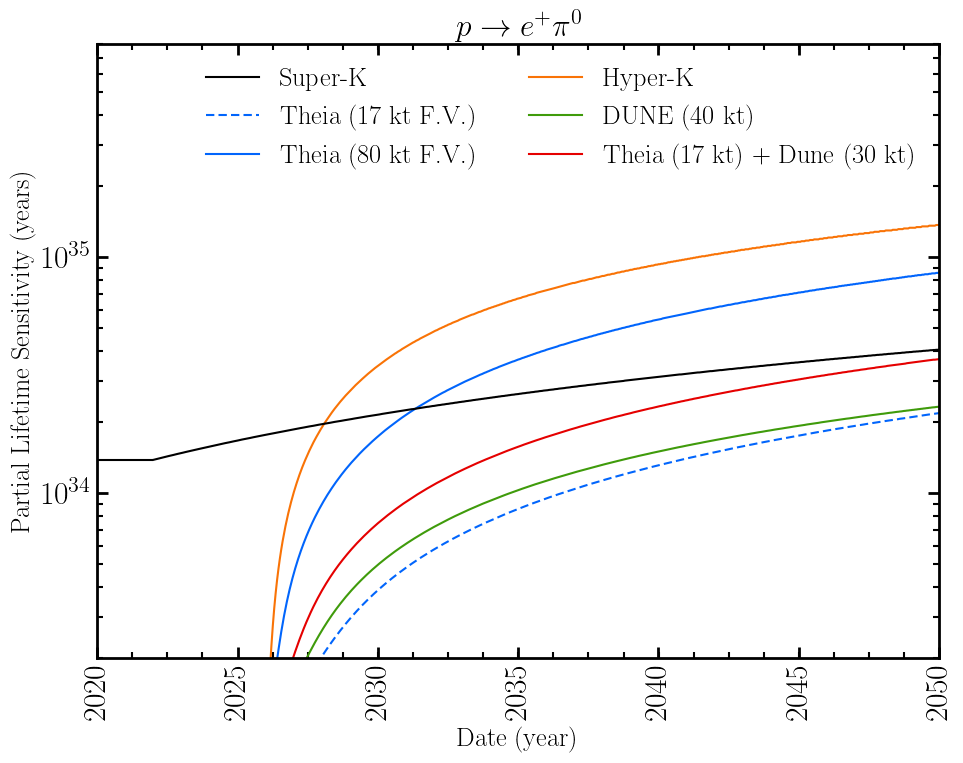

In [4]:
'''
P -> e Pi
'''

t = np.linspace(1e-2,50,1001) #years

timenow = dates.date2num( datetime.date(2019,1,1) )
rt = dates.num2date( timenow + t*365.25 )
 
fig = plt.figure()
ax = fig.add_subplot(111)

bpm = 0.04/20.5
fv = 17
hkb = 0.68/1000.0
tkb = 0.326/1000.0

dune_efficiency = 0.29 #Dune says 45%, bob says 29%

superk = detector(name='Super-K', mass=20.5, backgroundRate=bpm*20.5, startTime=-15, stopTime=0)
v = superk.getSensitivityCurve(t)
ax.plot(dates.num2date( timenow+ t[t<3]*365.25), v[t<3], label='Super-K', color=clrs['sk'])
print(v)

theia = detector(name='Theia', mass=fv, backgroundRate=tkb*fv, startTime=7)
v = theia.getSensitivityCurve(t)
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')

clean = detector(mass=fv, backgroundRate=tkb*fv, startTime=7)
v2 = clean.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Theia ({fv} kt F.V.)', color=clrs['theia'], dashes=[4,2])

## Large Theia
fv = 80
clean = detector(mass=fv, backgroundRate=tkb*fv, startTime=7)
v2 = clean.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Theia ({fv} kt F.V.)', color=clrs['theia'])

print("Theia 10-year: %0.2e"%(v2[t>=17][0])  )
print("Theia 20-year: %0.2e"%(v2[t>=27][0])  )

skgd = detector(name='SKGD', mass=20.5, backgroundRate=bpm*20.5/10, startTime=3)
v = skgd.getSensitivityCurve(t)
#plt.plot(t, v, label='SKGD')

hyperk = detector(mass=187, backgroundRate=hkb*187, startTime=7)
v = hyperk.getSensitivityCurve(t)
ax.plot(rt, v, label='Hyper-K', color=clrs['hk'])

dune = detector(mass=40, backgroundRate=1*0.04, startTime=7, efficiency=dune_efficiency)
v = dune.getSensitivityCurve(t, mol=39.948, protons=18)
ax.plot(rt, v, label='DUNE (40 kt)', color=clrs['dune'])

mdune = detector(mass=30, backgroundRate=1*0.03, startTime=7, efficiency=dune_efficiency)
v = mdune.getSensitivityCurve(t, mol=39.948, protons=18)
#ax.plot(rt, v, label='mDUNE', color='xkcd:green', dashes=[4,2])

theia = detector(name='Theia', mass=17, backgroundRate=tkb*10, startTime=7)
v = theia.getSensitivityCurve(t)
#ax.plot(rt, v, label=f'Theia (10 kt F.V.)')

v = theia.combinedResults(mdune)
ax.plot(rt, v, label='Theia (17 kt) + Dune (30 kt)', color=clrs['combined'])

vspec = skgd.combinedResults(superk)
ax.plot(rt, vspec, color=clrs['sk'])

#ax.set_title('$p \\rightarrow e^+\pi^0$')
ax.set_title(r'$p \rightarrow e^+\pi^0$')
ax.set_yscale('log')
#ax.set_xlim(0,50)
ax.set_xlim(datetime.date(2020,1,1), datetime.date(2050,1,1))
ax.set_ylim(2e33,8e35)
ax.legend(ncol=2)
ax.set_xlabel('Date (year)')
ax.set_ylabel('Partial Lifetime Sensitivity (years)')
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_formatter( dates.DateFormatter('%Y') )
ax.xaxis.set_major_locator(dates.YearLocator(5))
savefig('nd_epi.pdf')
#plt.tight_layout()
plt.show()

/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: overflow encountered in power
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: invalid value encountered in power
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: invalid value encountered in multiply
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: invalid value encountered in divide
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
/home/morgan/projects/booky/env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_4318/962035889.py:44: RuntimeWarning: divide by zero encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:44: Runtime

Theia 10-year: 3.80e+34
Theia 20-year: 6.15e+34
Exposure 800.66
Juon protons: 6.685435918842227e+33


/tmp/ipykernel_4318/962035889.py:78: RuntimeWarning: divide by zero encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:78: RuntimeWarning: invalid value encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:81: RuntimeWarning: divide by zero encountered in divide
  return self.norm / V


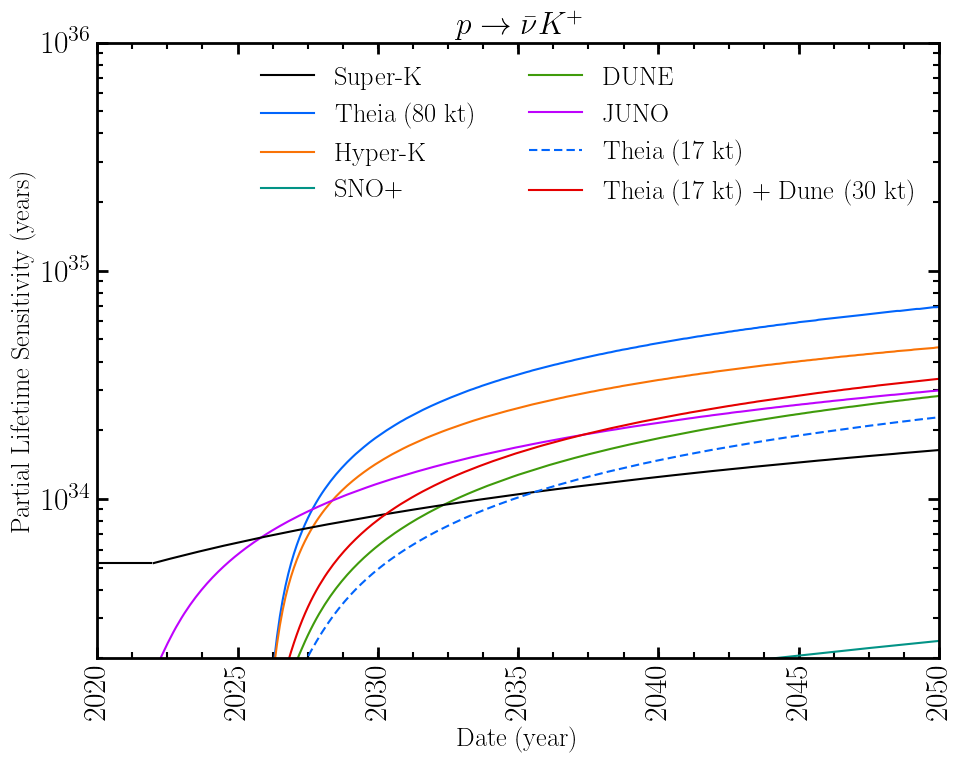

In [5]:
'''
P -> nu K
'''

t = np.linspace(1e-2,100,1001) #years

timenow = dates.date2num( datetime.date(2019,1,1) )
rt = dates.num2date( timenow + t*365.25 )
 
fig = plt.figure()
ax = fig.add_subplot(111)

bpm = 0.14/20.5
hkb = 1.6/1000.0*2
hke = 0.127+0.108
fv = 80

theia_eff = (0.65)*0.845
theia_bkg = (1.2 + 1.3)*fv/1000.0

superk = detector(name='Super-K', mass=20.5, backgroundRate=bpm*20.5, startTime=-15, stopTime=0, efficiency=0.20)
v = superk.getSensitivityCurve(t)
ax.plot(dates.num2date( timenow+ t[t<3]*365.25), v[t<3], label='Super-K', color=clrs['sk'])


theia = detector(name='Theia', mass=fv, backgroundRate=1.6*fv/2., startTime=7, efficiency=1.0)
v = theia.getSensitivityCurve(t)
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')

clean = detector(mass=fv, backgroundRate=theia_bkg, startTime=7, efficiency=theia_eff)
#clean = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = clean.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Theia ({fv} kt)', color=clrs['theia'])
print("Theia 10-year: %0.2e"%(v2[t>=17][0])  )
print("Theia 20-year: %0.2e"%(v2[t>=27][0])  )
print("Exposure %0.2f"%(fv*(t[t>=17][0]-7)))

skgd = detector(name='SKGD', mass=20.5, backgroundRate=bpm*20.5/10, startTime=3, efficiency=0.20)
v = skgd.getSensitivityCurve(t)
#plt.plot(t, v, label='SKGD')

hkmass = 187
hyperk = detector(mass=hkmass, backgroundRate=hkb*hkmass, startTime=7, efficiency=hke)
v = hyperk.getSensitivityCurve(t)
ax.plot(rt, v, label='Hyper-K', color=clrs['hk'])

## SNOPLUS
snoplus = detector(mass=1.0, backgroundRate=2.5*0.001, startTime=0, efficiency=0.65*0.845)
v = snoplus.getSensitivityCurve(t)
ax.plot(rt, v, label="SNO+", color="xkcd:teal")

#dune = detector(mass=40, backgroundRate=1*0.04, startTime=7, efficiency=0.97)
dune = detector(mass=40, backgroundRate=1.25*0.04, startTime=7, efficiency=0.30)
v = dune.getSensitivityCurve(t)
ax.plot(rt, v, label='DUNE', color=clrs['dune'])

juno = detector(mass=20, backgroundRate=2.5*0.02, startTime=2, efficiency=0.65*0.845)
print('Juon protons:', juno._massToFreeProtons())
v = juno.getSensitivityCurve(t)
ax.plot(rt, v, label='JUNO', color=clrs['juno'])

vspec = skgd.combinedResults(superk)
ax.plot(rt, vspec, color=clrs['sk'])

#bigTheia = detector(mass=100, backgroundRate=hkb*100/2., startTime=7, efficiency=0.65*0.845)
#v2 = bigTheia.getSensitivityCurve(t)
#ax.plot(rt, v2, label=f'Theia (100 kT F.V.)', color=clrs['theia'], dashes=[6,2])

#mTheia = detector(mass=17, backgroundRate=2.5/1000*17, startTime=7, efficiency=0.65*0.845)
mTheia = detector(mass=17, backgroundRate=theia_bkg*17/fv, startTime=7, efficiency=theia_eff)
v = mTheia.getSensitivityCurve(t)
ax.plot(rt, v, label='Theia (17 kt)', color=clrs['theia'], dashes=[4,2])
mDune = detector(mass=30, backgroundRate=1.25*0.04, startTime=7, efficiency=0.30)
v = mDune.getSensitivityCurve(t, mol=39.948, protons=18)
v = mTheia.combinedResults(mDune)
ax.plot(rt, v, label='Theia (17 kt) + Dune (30 kt)', color=clrs['combined'])


ax.set_yscale('log')
#ax.set_xlim(0,50)
ax.set_xlim(datetime.date(2020,1,1), datetime.date(2050,1,1))
ax.set_ylim(2e33,10e35)
ax.legend(ncol=2)
ax.set_xlabel('Date (year)')
ax.set_ylabel('Partial Lifetime Sensitivity (years)')
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_formatter( dates.DateFormatter('%Y') )
ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.set_title(r'$p \rightarrow \bar{\nu} K^+$')

savefig('nd_nuk.pdf')
plt.show()

solar 48.666666666666664
atmo 4.269005847953216
muon 42.69005847953216
95.62573099415204
17 theia has a background rate of 1625.6374269005846 events per year


/tmp/ipykernel_4318/962035889.py:34: RuntimeWarning: overflow encountered in power
  normal = lambda s, b, n: np.e**(-(n-s-b)**2/2/(s+b))
/home/morgan/projects/booky/env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_4318/962035889.py:59: RuntimeWarning: divide by zero encountered in divide
  return self.norm / (V)


17 theia has a background rate of 1625.6374269005846 events per year
80 theia has a background rate of 7650.058479532163 events per year


/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: overflow encountered in power
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: invalid value encountered in multiply
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)


kamland: 3.479563539226154e+31


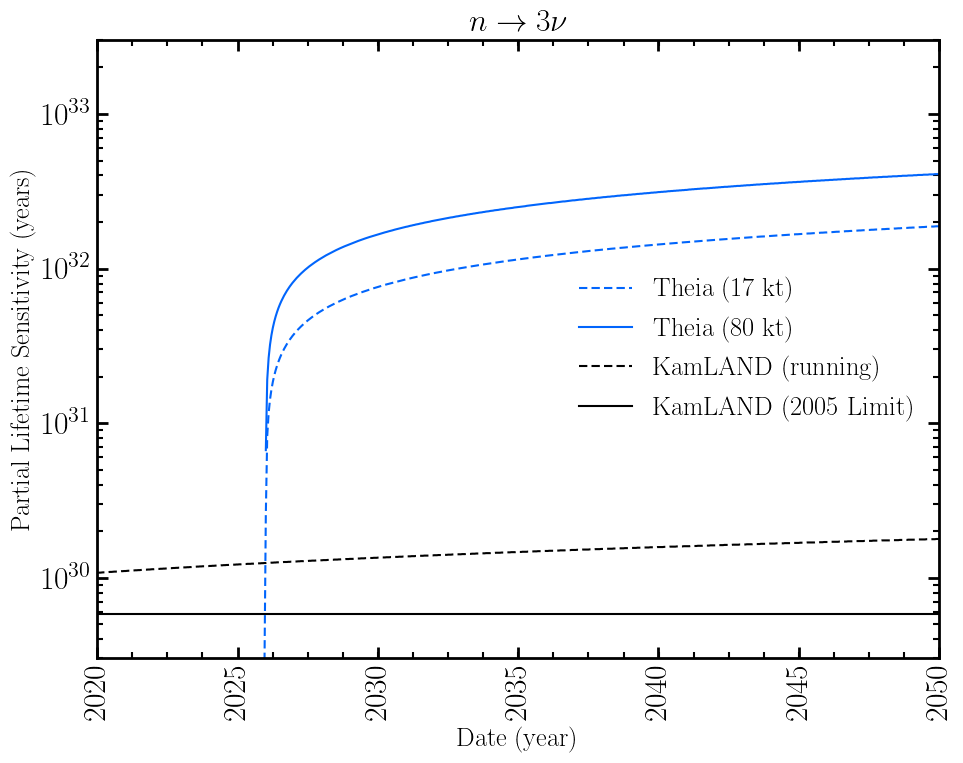

In [6]:
'''
n -> 3nu
'''
t = np.linspace(1e-2,50,1001) #years

timenow = dates.date2num( datetime.date(2019,1,1) )
rt = dates.num2date( timenow + t*365.25 )
 
fig = plt.figure()
ax = fig.add_subplot(111)

solar = 1/10/0.75*365
print('solar', solar)
atmo = 1/114/0.75*365
print('atmo', atmo)
muon = 10/114*365/0.75
print('muon', muon)

bpm = solar + atmo + muon
kamland = 0.978*2
print(bpm)

#superk = detector(name='Super-K', mass=20.5, backgroundRate=bpm*20.5, startTime=-15, stopTime=0, efficiency=0.20)
#v = superk.getSensitivityCurve(t)
#plt.plot(t[t<5], v[t<5], label='Super-K')
fv = 17
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
ax.plot(rt, v, label=f'Theia ({fv} kt)', color=clrs['theia'],dashes=[4,2])

#Little theia
fv = 17
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
#ax.plot(rt, v, label=f'Theia ({fv} kt F.V.)', color=clrs['theia'],dashes=[4,2])
##

#Big theia
fv = 80
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Big Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
ax.plot(rt, v, label=f'Theia ({fv} kt)', color=clrs['theia'])
##


juno = detector(mass=20, backgroundRate=kamland*20, startTime=2, efficiency=0.058,
                s=np.linspace(0,20,20001), norm=1e32)
v = juno.getSensitivityCurve(t, pdf='gaus')

juno = detector(mass=20, backgroundRate=kamland*20, startTime=2, efficiency=0.058,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = juno.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
#ax.plot(rt, v, label='JUNO', color=clrs['juno'])

## Juno is a no-go, the 2s veto kills it
## Add continued KamLAND
kamland = detector(mass=0.408*(3.48/13.64), backgroundRate=kamland, startTime=-19, efficiency=0.018,
                  s=np.linspace(0,20,20001), norm=5e29)
v = kamland.getSensitivityCurve(t)
print('kamland:', kamland.tp)
ax.plot(rt, v, label='KamLAND (running)', color='xkcd:black', dashes=[4,2])

#clean = detector(mass=50, backgroundRate=bpm*50/10, startTime=10, efficiency=1.0)
#v2 = clean.getSensitivityCurve(t)
#plt.plot(t, v2, label='ASDC Tagging (50 kT F.V.)')

#skgd = detector(name='SKGD', mass=20.5, backgroundRate=bpm*20.5/10, startTime=5, efficiency=0.20)
#v = skgd.getSensitivityCurve(t)
#plt.plot(t, v, label='SKGD')

#hyperk = detector(mass=187, backgroundRate=bpm*187, startTime=5, efficiency=0.20)
#v = hyperk.getSensitivityCurve(t)
#plt.plot(t, v, label='Hyper-K')

#vspec = skgd.combinedResults(superk)
#plt.plot(t, vspec, label='SK + SKGD')
ax.axhline(5.8e29, color='xkcd:black', label='KamLAND (2005 Limit)')

#ax.set_title('$n \\rightarrow 3\\nu$')
ax.set_title(r'$n \rightarrow 3\nu$')
ax.set_yscale('log')
ax.set_ylim(3e29,3e33)
ax.set_xlim(datetime.date(2020,1,1), datetime.date(2050,1,1))
ax.set_xlabel('Date (year)')
ax.set_ylabel('Partial Lifetime Sensitivity (years)')
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_formatter( dates.DateFormatter('%Y') )
ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.legend()
savefig('nd_invisible.pdf')
plt.show()

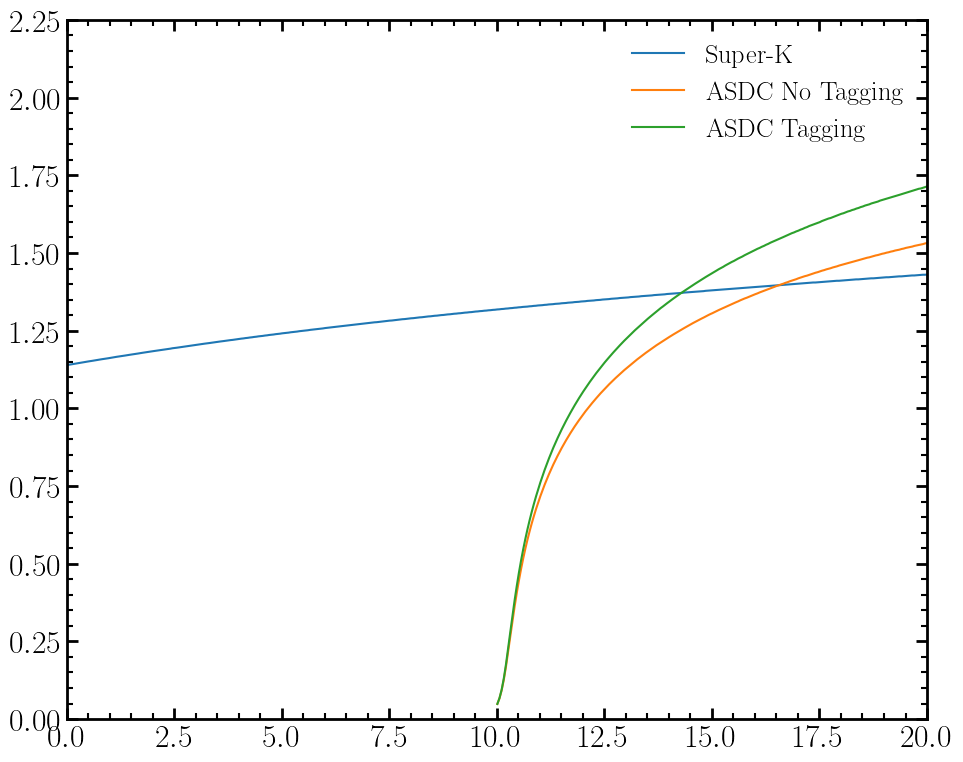

In [7]:
t = np.linspace(1e-2,50,1001) #years

tnot_superk = 14.95
superk = detector(name='Super-K', mass=20.5, backgroundRate=0.041)
v = np.log10(superk.getSensitivityCurve(t) / 1e33)
plt.plot(t-tnot_superk, v, label='Super-K')

theia = detector(name='Theia', mass=100, backgroundRate=0.21)
v = np.log10(theia.getSensitivityCurve(t)/1e33)
plt.plot(t+10, v, label='ASDC No Tagging')


clean = detector(mass=100, backgroundRate=0.021)
v2 = np.log10(clean.getSensitivityCurve(t)/1e33)
plt.plot(t+10, v2, label='ASDC Tagging')


plt.xlim(0,20)
plt.ylim(0,2.25)

plt.legend()
plt.show()

In [8]:
%%script False
## Super-K paper
# s = lambda, little lambda, epsilon
from scipy.special import gamma
p = lambda s, b, n: np.e**(-(s+b))*(s+b)**n/gamma(n+1)
bkg = 0.61
xpo = (306.3)*1e9*6.022e23/18 * 10
eff = 0.39

print(xpo)

def limit(f, x):
    fn = f / np.sum(f)
    k = np.cumsum(fn)
    return x[np.argmax(k>=0.9)]

def lifetime(lim):
    return 1/(lim/xpo/eff)

sx = np.linspace(0,10,1001)
vnull = limit(p(sx,bkg,bkg),sx)
vtrue = limit(p(sx,bkg,0),sx)
print(vnull, lifetime(vnull))
print(vtrue, lifetime(vtrue))

plt.plot(sx,p(sx,bkg,bkg))
plt.plot(sx,p(sx,bkg,0))
plt.show()

Couldn't find program: 'False'


In [9]:
# Total to Fiducial
a = 2.0 #Cut from wall

def fiducial(total, cut):
    return 2*np.pi*((total/2/np.pi)**(1/3)-cut)**3

print(fiducial(25000,a))
## Right cylinder

16678.393149325297


/tmp/ipykernel_4318/962035889.py:36: RuntimeWarning: invalid value encountered in power
  normal = lambda s, b, n: np.e**(-(s+b)/k)*((s+b)/k)**n/gamma(n/k+1)
/tmp/ipykernel_4318/962035889.py:44: RuntimeWarning: divide by zero encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:44: RuntimeWarning: invalid value encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:59: RuntimeWarning: divide by zero encountered in divide
  return self.norm / (V)


Juon protons: 6.685435918842227e+33


/tmp/ipykernel_4318/962035889.py:78: RuntimeWarning: divide by zero encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:78: RuntimeWarning: invalid value encountered in divide
  F = ( F.T / np.sum(F.T, axis=0) ).T
/tmp/ipykernel_4318/962035889.py:81: RuntimeWarning: divide by zero encountered in divide
  return self.norm / V


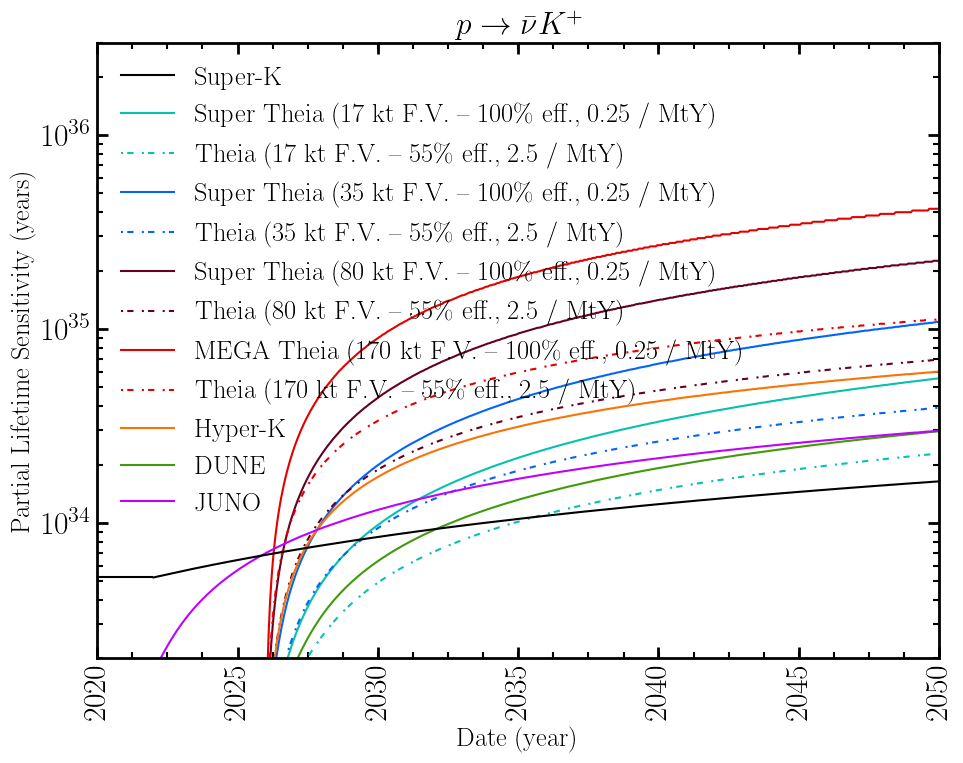

In [10]:
'''
P -> nu K
SUPER THEIA !!!
'''

t = np.linspace(1e-2,50,1001) #years

timenow = dates.date2num( datetime.date(2019,1,1) )
rt = dates.num2date( timenow + t*365.25 )
 
fig = plt.figure()
ax = fig.add_subplot(111)

bpm = 0.14/20.5
hkb = 1.6/1000.0
hke = 0.127+0.108
fv = 35

superk = detector(name='Super-K', mass=20.5, backgroundRate=bpm*20.5, startTime=-15, stopTime=0, efficiency=0.20)
v = superk.getSensitivityCurve(t)
ax.plot(dates.num2date( timenow+ t[t<3]*365.25), v[t<3], label='Super-K', color=clrs['sk'])


theia = detector(name='Awesome Theia', mass=fv, backgroundRate=0.1, startTime=7, efficiency=1.0)
v = theia.getSensitivityCurve(t)
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')

##### 17 kT Theia
fv = 17
nclr = 'xkcd:turquoise'
clean = detector(mass=fv, backgroundRate=2.5/1000*fv/10., startTime=7, efficiency=0.65*0.845*0+1)
#clean = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = clean.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Super Theia ({fv} kt F.V. -- 100\% eff., 0.25 / MtY)', color=nclr)

#clean = detector(mass=fv, backgroundRate=hkb*fv*0, startTime=7, efficiency=0.65*0.845*0+1)
t_juno = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = t_juno.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Theia ({fv} kt F.V. -- 55\% eff., 2.5 / MtY)', color=nclr, dashes=[1,2,3,4])
#####

##### 35 kT Theia
fv = 35
clean = detector(mass=fv, backgroundRate=2.5/1000*fv/10., startTime=7, efficiency=0.65*0.845*0+1)
#clean = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = clean.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Super Theia ({fv} kt F.V. -- 100\% eff., 0.25 / MtY)', color=clrs['theia'])

#clean = detector(mass=fv, backgroundRate=hkb*fv*0, startTime=7, efficiency=0.65*0.845*0+1)
t_juno = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = t_juno.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Theia ({fv} kt F.V. -- 55\% eff., 2.5 / MtY)', color=clrs['theia'], dashes=[1,2,3,4])
#####

##### 80 kT Theia
fv = 80
nclr = 'xkcd:maroon'
clean = detector(mass=fv, backgroundRate=2.5/1000*fv/10., startTime=7, efficiency=0.65*0.845*0+1)
#clean = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = clean.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Super Theia ({fv} kt F.V. -- 100\% eff., 0.25 / MtY)', color=nclr)

#clean = detector(mass=fv, backgroundRate=hkb*fv*0, startTime=7, efficiency=0.65*0.845*0+1)
t_juno = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = t_juno.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Theia ({fv} kt F.V. -- 55\% eff., 2.5 / MtY)', color=nclr, dashes=[1,2,3,4])
#####

##### 170 kT MEGA Theia
fv = 170
nclr = 'xkcd:red'
clean = detector(mass=fv, backgroundRate=2.5/1000*fv/10., startTime=7, efficiency=0.65*0.845*0+1)
#clean = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = clean.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'MEGA Theia ({fv} kt F.V. -- 100\% eff., 0.25 / MtY)', color=nclr)

#clean = detector(mass=fv, backgroundRate=hkb*fv*0, startTime=7, efficiency=0.65*0.845*0+1)
t_juno = detector(mass=fv, backgroundRate=2.5/1000*fv, startTime=7, efficiency=0.65*0.845)
v2 = t_juno.getSensitivityCurve(t)
ax.plot(rt, v2, label=f'Theia ({fv} kt F.V. -- 55\% eff., 2.5 / MtY)', color=nclr, dashes=[1,2,3,4])
#####

skgd = detector(name='SKGD', mass=20.5, backgroundRate=bpm*20.5/10, startTime=3, efficiency=0.20)
v = skgd.getSensitivityCurve(t)
#plt.plot(t, v, label='SKGD')

hkmass = 187
hyperk = detector(mass=hkmass, backgroundRate=hkb*hkmass, startTime=7, efficiency=hke)
v = hyperk.getSensitivityCurve(t)
ax.plot(rt, v, label='Hyper-K', color=clrs['hk'])

#dune = detector(mass=40, backgroundRate=1*0.04, startTime=7, efficiency=0.97)
dune = detector(mass=40, backgroundRate=1*0.04, startTime=7, efficiency=0.30)
v = dune.getSensitivityCurve(t)
ax.plot(rt, v, label='DUNE', color=clrs['dune'])

juno = detector(mass=20, backgroundRate=2.5*0.02, startTime=2, efficiency=0.65*0.845)
print('Juon protons:', juno._massToFreeProtons())
v = juno.getSensitivityCurve(t)
ax.plot(rt, v, label='JUNO', color=clrs['juno'])

vspec = skgd.combinedResults(superk)
ax.plot(rt, vspec, color=clrs['sk'])

#bigTheia = detector(mass=100, backgroundRate=hkb*100/2., startTime=7, efficiency=0.65*0.845)
#v2 = bigTheia.getSensitivityCurve(t)
#ax.plot(rt, v2, label=f'Theia (100 kT F.V.)', color=clrs['theia'], dashes=[6,2])

#mTheia = detector(mass=17, backgroundRate=2.5/1000*17, startTime=7, efficiency=0.65*0.845)
mTheia = detector(mass=17, backgroundRate=hkb*17, startTime=7, efficiency=0.65*0.845)
v = mTheia.getSensitivityCurve(t)
mDune = detector(mass=30, backgroundRate=1*0.04, startTime=7, efficiency=0.30)
v = mDune.getSensitivityCurve(t, mol=39.948, protons=18)
v = mTheia.combinedResults(mDune)
#ax.plot(rt, v, label='Theia (17 kt) + Dune (30 kt)', color=clrs['combined'])


ax.set_yscale('log')
#ax.set_xlim(0,50)
ax.set_xlim(datetime.date(2020,1,1), datetime.date(2050,1,1))
ax.set_ylim(2e33,3e36)
ax.legend()
ax.set_xlabel('Date (year)')
ax.set_ylabel('Partial Lifetime Sensitivity (years)')
ax.xaxis.set_tick_params(rotation=90)
ax.xaxis.set_major_formatter( dates.DateFormatter('%Y') )
ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.set_title(r'$p \rightarrow \bar{\nu} K^+$')

savefig('nuk.pdf')
plt.show()

Theia 10-year: 4.06e+34
Theia 20-year: 7.41e+34
Theia 10-year: 3.80e+34
Theia 20-year: 6.15e+34
Exposure 800.53


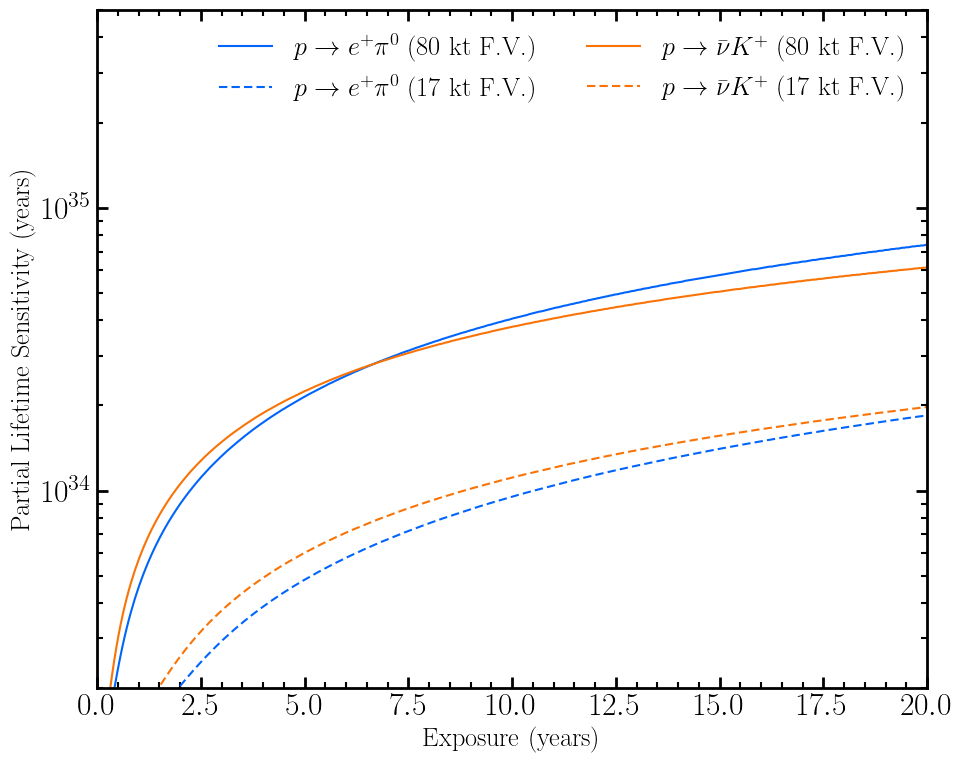

In [11]:
## Only Theia, arbitrary time
t = np.linspace(1e-2,50,1001) #years

timenow = dates.date2num( datetime.date(2019,1,1) )
rt = dates.num2date( timenow + t*365.25 )
 
fig = plt.figure()
ax = fig.add_subplot(111)

bpm = 0.04/20.5
fv = 17
hkb = 0.68/1000.0
tkb = 0.326/1000.0

dune_efficiency = 0.29 #Dune says 45%, bob says 29%

#### THEIA: EPI ####
mode = r'$p \rightarrow e^+\pi^0$'

## Large Theia
fv = 80
clean = detector(mass=fv, backgroundRate=tkb*fv, startTime=0)
v2 = clean.getSensitivityCurve(t)
ax.plot(t, v2, label=f'{mode} ({fv} kt F.V.)', color=clrs['theia'])

print("Theia 10-year: %0.2e"%(v2[t>=10][0])  )
print("Theia 20-year: %0.2e"%(v2[t>=20][0])  )

fv = 17
clean = detector(mass=fv, backgroundRate=tkb*fv, startTime=0)
v2 = clean.getSensitivityCurve(t)
ax.plot(t, v2, label=f'{mode} ({fv} kt F.V.)', color=clrs['theia'], dashes=[4,2])

#### THEIA: NuK ####
bpm = 0.14/20.5
hkb = 1.6/1000.0*2
hke = 0.127+0.108
fv = 80
mode = r'$p \rightarrow \bar{\nu} K^+$'
theia_eff = (0.65)*0.845
#theia_bkg = (1.2 + 1.3)*fv/1000.0
theia_bkg = (1.2 + 1.3)/1000.0


clean = detector(mass=fv, backgroundRate=theia_bkg*fv, startTime=0, efficiency=theia_eff)
v2 = clean.getSensitivityCurve(t)
ax.plot(t, v2, label=f'{mode} ({fv} kt F.V.)', color=clrs['hk'])
print("Theia 10-year: %0.2e"%(v2[t>=10][0])  )
print("Theia 20-year: %0.2e"%(v2[t>=20][0])  )
print("Exposure %0.2f"%(fv*(t[t>=17][0]-7)))


#mTheia = detector(mass=17, backgroundRate=2.5/1000*17, startTime=7, efficiency=0.65*0.845)
fv = 17
mTheia = detector(mass=fv, backgroundRate=theia_bkg*fv, startTime=0, efficiency=theia_eff)
v = mTheia.getSensitivityCurve(t)
ax.plot(t, v, label=f'{mode} ({fv} kt F.V.)', color=clrs['hk'], dashes=[4,2])

### INVISIBLE ###
'''
solar = 1/10/0.75*365
print('solar', solar)
atmo = 1/114/0.75*365
print('atmo', atmo)
muon = 10/114*365/0.75
print('muon', muon)

bpm = solar + atmo + muon
kamland = 0.978*2
print(bpm)

fv = 17
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
ax.plot(t, v, label=f'Theia ({fv} kt)', color=clrs['dune'],dashes=[4,2])

#Little theia
fv = 17
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=0, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=0, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
#ax.plot(rt, v, label=f'Theia ({fv} kt F.V.)', color=clrs['theia'],dashes=[4,2])
##

#Big theia
fv = 80
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=0, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Big Theia', mass=fv, backgroundRate=bpm*fv, startTime=7, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
ax.plot(t, v, label=f'Theia ({fv} kt)', color=clrs['dune'])
##
##
'''

#ax.set_title('$p \\rightarrow e^+\pi^0$')
ax.set_xlim(0, 20)
#ax.set_title(r'$p \rightarrow e^+\pi^0$')
ax.set_yscale('log')
#ax.set_xlim(0,50)
#ax.set_xlim(datetime.date(2020,1,1), datetime.date(2050,1,1))
ax.set_ylim(2e33,5e35)
ax.legend(ncol=2)
ax.set_xlabel('Exposure (years)')
ax.set_ylabel('Partial Lifetime Sensitivity (years)')
#ax.xaxis.set_tick_params(rotation=90)
#ax.xaxis.set_major_formatter( dates.DateFormatter('%Y') )
#ax.xaxis.set_major_locator(dates.YearLocator(5))
savefig('nd_epi.pdf')
#plt.tight_layout()
plt.show()

solar 48.666666666666664
atmo 4.269005847953216
muon 42.69005847953216
95.62573099415204
80 theia has a background rate of 7650.058479532163 events per year
17 theia has a background rate of 1625.6374269005846 events per year


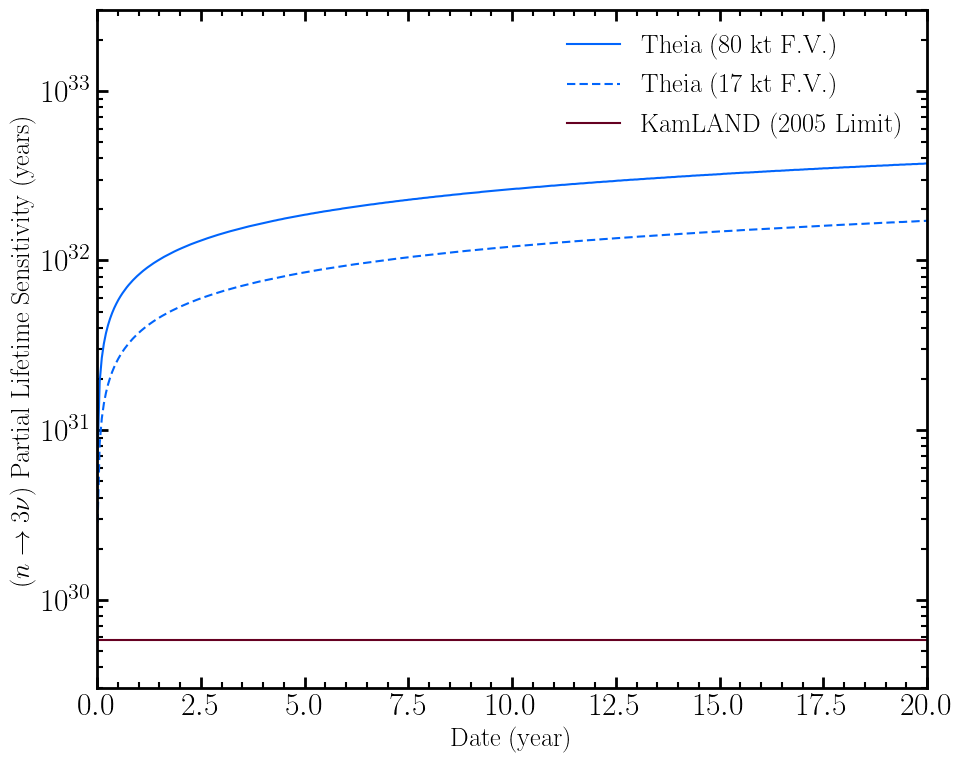

In [12]:
'''
n -> 3nu
'''
t = np.linspace(1e-2,50,1001) #years

fig = plt.figure()
ax = fig.add_subplot(111)

solar = 1/10/0.75*365
print('solar', solar)
atmo = 1/114/0.75*365
print('atmo', atmo)
muon = 10/114*365/0.75
print('muon', muon)

bpm = solar + atmo + muon
kamland = 0.978*2
print(bpm)

#superk = detector(name='Super-K', mass=20.5, backgroundRate=bpm*20.5, startTime=-15, stopTime=0, efficiency=0.20)
#v = superk.getSensitivityCurve(t)
#plt.plot(t[t<5], v[t<5], label='Super-K')


#Big theia
fv = 80
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=0, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Big Theia', mass=fv, backgroundRate=bpm*fv, startTime=0, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
ax.plot(t, v, label=f'Theia ({fv} kt F.V.)', color=clrs['theia'])
##

fv = 17
theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=0, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=1e32)
v = theia.getSensitivityCurve(t, pdf='gaus')
#plt.plot(t, v, label=f'ASDC No Tagging ({fv} kT F.V.)')
print(f'{fv} theia has a background rate of {bpm*fv} events per year')

theia = detector(name='Theia', mass=fv, backgroundRate=bpm*fv, startTime=0, efficiency=0.45,
                s=np.linspace(0,20,20001), norm=5e30)
v2 = theia.getSensitivityCurve(t, pdf='gaus')

v[v<1e31] = v2[v<1e31]
ax.plot(t, v, label=f'Theia ({fv} kt F.V.)', color=clrs['theia'],dashes=[4,2])


## Juno is a no-go, the 2s veto kills it
## Add continued KamLAND
#kamland = detector(mass=0.408*(3.48/13.64), backgroundRate=kamland, startTime=-19, efficiency=0.018,
#                  s=np.linspace(0,20,20001), norm=5e29)
#v = kamland.getSensitivityCurve(t)
#print('kamland:', kamland.tp)
#ax.plot(t, v, label='KamLAND (running)', color='xkcd:black', dashes=[4,2])

#clean = detector(mass=50, backgroundRate=bpm*50/10, startTime=10, efficiency=1.0)
#v2 = clean.getSensitivityCurve(t)
#plt.plot(t, v2, label='ASDC Tagging (50 kT F.V.)')

#skgd = detector(name='SKGD', mass=20.5, backgroundRate=bpm*20.5/10, startTime=5, efficiency=0.20)
#v = skgd.getSensitivityCurve(t)
#plt.plot(t, v, label='SKGD')

#hyperk = detector(mass=187, backgroundRate=bpm*187, startTime=5, efficiency=0.20)
#v = hyperk.getSensitivityCurve(t)
#plt.plot(t, v, label='Hyper-K')

#vspec = skgd.combinedResults(superk)
#plt.plot(t, vspec, label='SK + SKGD')
ax.axhline(5.8e29, color='xkcd:maroon', label='KamLAND (2005 Limit)')

#ax.set_title('$n \\rightarrow 3\\nu$')
#ax.set_title(r'$n \rightarrow 3\nu$')
ax.set_yscale('log')
ax.set_ylim(3e29,3e33)
#ax.set_xlim(datetime.date(2020,1,1), datetime.date(2050,1,1))
ax.set_xlabel('Date (year)')
#ax.set_ylabel('Partial Lifetime Sensitivity (years)')
ax.set_ylabel(r'$(n \rightarrow 3\nu)$ Partial Lifetime Sensitivity (years)')
#ax.xaxis.set_tick_params(rotation=90)
#ax.xaxis.set_major_formatter( dates.DateFormatter('%Y') )
#ax.xaxis.set_major_locator(dates.YearLocator(5))
ax.set_xlim(0, 20)
ax.legend()
savefig('nd_invisible.pdf')
plt.show()